Hopfion Optical Simulation Program

This program simulates Hopfion optical structures, including phase calculation
of metalens arrays, optical field propagation, and polarization state analysis.

Main Features:
1. Create metalens arrays
2. Calculate optical field propagation
3. Generate polarization color maps
4. Save simulation results

Author: Yu-Chen-Yi
Date: 2025-10-28

In [1]:
import os
from typing import List, Dict, Tuple
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb

# Set environment variable to avoid duplicate library warnings
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

# Import optiprop library
import optiprop

In [ ]:
class SimulationConfig:
    """Simulation configuration class for centralized parameter management"""
    
    def __init__(self):
        # Device configuration
        self.device = 'cpu'
        self.dtype = torch.float32
        
        # Near-field grid configuration
        self.near_field_pixel_size = 650e-9  # Sampling interval (m)
        self.near_field_field_Lx = 1000e-6   # Physical size in X direction (m)
        self.near_field_field_Ly = 1000e-6   # Physical size in Y direction (m)
        
        # Metalens configuration
        self.wavelength = 1.31e-6            # Design wavelength (m)
        self.lens_diameter = 100e-6          # Lens diameter (m)
        self.metalens_focal_length = 575e-6 / 1.46  # Focal length (m): substrate thk (575um) / substrate index (1.46)
        
        # Aperture configuration
        self.aperture_defocus_distance =  0e-6  # Aperture defocus distance (m)
        self.aperture_diameter = 30e-6       # Aperture diameter (m)
        self.aperture_decenter_distance = 0e-6  # Aperture offset distance (m)
        self.aperture_decenter_angle = np.pi/2  # Aperture offset angle (rad)
        
        # Simulation parameters
        self.pce = 1.0                       # Phase conversion efficiency
        self.dummy_value = 1.1                 # Dummy value
        self.far_field_propagation_factor = 9  # Far-field propagation factor
        
        # Output configuration
        self.save_folder = 'result'
        self.output_limits = {'xlim': [-40, 40], 'ylim': [-40, 40]}  # Output image range (μm)


class MetalensArray:
    """Metalens array class for managing lens positions and parameters"""
    
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.rcp_lenses = self._create_rcp_lens_array()
        self.lcp_lenses = self._create_lcp_lens_array()
    
    def _create_rcp_lens_array(self) -> List[Dict]:
        """Create right circularly polarized metalens array"""
        return [
            {'cx': -200e-6, 'cy': 0e-6, 'amplitude': 1},
            {'cx': +200e-6, 'cy': 0e-6, 'amplitude': 1},
            {'cx': 0e-6, 'cy': -200e-6, 'amplitude': 1},
            {'cx': 0e-6, 'cy': 200e-6, 'amplitude': 1},
            {'cx': -400e-6, 'cy': 0e-6, 'amplitude': -1/2},
            {'cx': 400e-6, 'cy': 0e-6, 'amplitude': -1/2},
            {'cx': 0e-6, 'cy': -400e-6, 'amplitude': -1/2},
            {'cx': 0e-6, 'cy': 400e-6, 'amplitude': -1/2},
        ]
    
    def _create_lcp_lens_array(self) -> List[Dict]:
        """Create left circularly polarized metalens array"""
        return [
            {'cx': -200e-6, 'cy': 100e-6, 'amplitude': 1j},
            {'cx': -200e-6, 'cy': -100e-6, 'amplitude': 1j},
            {'cx': 200e-6, 'cy': 100e-6, 'amplitude': -1j},
            {'cx': 200e-6, 'cy': -100e-6, 'amplitude': -1j},
            {'cx': -100e-6, 'cy': 200e-6, 'amplitude': 1},
            {'cx': 100e-6, 'cy': 200e-6, 'amplitude': 1},
            {'cx': -100e-6, 'cy': -200e-6, 'amplitude': -1},
            {'cx': 100e-6, 'cy': -200e-6, 'amplitude': -1},
        ]


In [3]:
class OpticalFieldCalculator:
    """Optical field calculator class for handling metalens and aperture field calculations"""
    
    def __init__(self, config: SimulationConfig, input_field, metalens_array: MetalensArray):
        self.config = config
        if config.dtype == torch.float32:
            self.field_dtype = torch.complex64
        elif config.dtype == torch.float64:
            self.field_dtype = torch.complex128
        else:
            raise ValueError("Invalid dtype")
        self.input_field = input_field
        self.metalens_array = metalens_array
    
    def calculate_metalens_field(self, lens_config: Dict, wavelength_sign: int, 
                                field_type: str = "phase") -> torch.Tensor:
        """
        Calculate optical field for a single metalens
        
        Args:
            lens_config: Lens configuration dictionary containing cx, cy, amplitude
            wavelength_sign: Wavelength sign (1 or -1)
            field_type: Field type ("phase" or "incident")
        
        Returns:
            Calculated optical field tensor
        """
        if field_type == "phase":
            element = optiprop.EqualPathPhase(self.input_field)
            element.calculate_phase(
                focal_length=self.config.metalens_focal_length,
                design_lambda=wavelength_sign * self.config.wavelength,
                lens_diameter=self.config.lens_diameter,
                lens_center=[lens_config['cx'], lens_config['cy']],
                aperture_type='circle',
                aperture_size=[self.config.lens_diameter],
                amplitude=lens_config['amplitude'] * self.config.pce,
                phase_offset=0,
            )
        else:  # incident field
            element = optiprop.IncidentField(self.input_field)
            element.calculate_phase(
                incident_angle=[0, 0],
                n=1,
                design_lambda=self.config.wavelength,
                lens_center=[lens_config['cx'], lens_config['cy']],
                aperture_type='circle',
                aperture_size=[self.config.lens_diameter],
                amplitude=(1 - abs(lens_config['amplitude']) * self.config.pce),
                phase_offset=0,
            )
        
        return element.U0
    
    def calculate_aperture_field(self, lens_center: Tuple[float, float]) -> torch.Tensor:
        """
        Calculate aperture field
        
        Args:
            lens_center: Lens center coordinates (cx, cy)
        
        Returns:
            Aperture field tensor
        """
        aperture_x = lens_center[0] + self.config.aperture_decenter_distance * np.cos(self.config.aperture_decenter_angle)
        aperture_y = lens_center[1] + self.config.aperture_decenter_distance * np.sin(self.config.aperture_decenter_angle)
        
        aperture_element = optiprop.IncidentField(self.input_field)
        aperture_element.calculate_phase(
            incident_angle=[0, 0],
            n=1,
            design_lambda=self.config.wavelength,
            lens_center=[aperture_x, aperture_y],
            aperture_type='circle',
            aperture_size=[self.config.aperture_diameter],
        )
        
        return aperture_element.U0
    
    def calculate_cross_polarized_field(self, polarization_type) -> torch.Tensor:
        """Calculate cross-polarized field (RCP -> LCP)"""
        cross_polarized_field = torch.zeros_like(self.input_field.X, dtype=self.field_dtype)
        if polarization_type == "LCP":
            lcp_lenses = self.metalens_array.lcp_lenses
            rcp_lenses = self.metalens_array.rcp_lenses
        elif polarization_type == "RCP":
            lcp_lenses = self.metalens_array.rcp_lenses
            rcp_lenses = self.metalens_array.lcp_lenses
        else:
            raise ValueError("Invalid polarization type")
        
        for lcp_lens, rcp_lens in zip(lcp_lenses, rcp_lenses):
            # LCP lens phase field
            lcp_phase = self.calculate_metalens_field(lcp_lens, 1, "phase")
            cross_polarized_field += lcp_phase
            
            # RCP lens phase field (inverted wavelength)
            rcp_phase = self.calculate_metalens_field(rcp_lens, -1, "phase")
            cross_polarized_field += rcp_phase
        
        return cross_polarized_field
    
    def calculate_co_polarized_field(self, polarization_type) -> torch.Tensor:
        """Calculate co-polarized field (LCP -> LCP)"""
        co_polarized_field = torch.zeros_like(self.input_field.X, dtype=self.field_dtype)
        if polarization_type == "LCP":
            lcp_lenses = self.metalens_array.lcp_lenses
            rcp_lenses = self.metalens_array.rcp_lenses
        elif polarization_type == "RCP":
            lcp_lenses = self.metalens_array.rcp_lenses
            rcp_lenses = self.metalens_array.lcp_lenses
        else:
            raise ValueError("Invalid polarization type")
        
        for lcp_lens, rcp_lens in zip(lcp_lenses, rcp_lenses):
            # LCP lens incident field
            lcp_incident = self.calculate_metalens_field(lcp_lens, 1, "incident")
            co_polarized_field += lcp_incident
            
            # RCP lens incident field
            rcp_incident = self.calculate_metalens_field(rcp_lens, 1, "incident")
            co_polarized_field += rcp_incident
        
        return co_polarized_field
    
    def calculate_aperture_mask(self) -> torch.Tensor:
        """Calculate aperture mask"""
        aperture_mask = torch.zeros_like(self.input_field.X, dtype=self.field_dtype)
        
        for lcp_lens, rcp_lens in zip(self.metalens_array.lcp_lenses, self.metalens_array.rcp_lenses):
            aperture_mask += self.calculate_aperture_field((lcp_lens['cx'], lcp_lens['cy']))
            aperture_mask += self.calculate_aperture_field((rcp_lens['cx'], rcp_lens['cy']))
        
        return aperture_mask
    
    def calculate_dummy_mask(self) -> torch.Tensor:
        """Calculate dummy mask for marking lens regions"""
        dummy_mask = torch.zeros_like(self.input_field.X, dtype=self.field_dtype)
        
        for lcp_lens, rcp_lens in zip(self.metalens_array.lcp_lenses, self.metalens_array.rcp_lenses):
            # Create dummy element to mark lens regions
            dummy_element = optiprop.IncidentField(self.input_field)
            dummy_element.calculate_phase(
                incident_angle=[0, 0],
                n=1,
                design_lambda=self.config.wavelength,
                lens_center=[lcp_lens['cx'], lcp_lens['cy']],
                aperture_type='circle',
                aperture_size=[self.config.lens_diameter],
            )
            dummy_mask += dummy_element.U0
            
            dummy_element = optiprop.IncidentField(self.input_field)
            dummy_element.calculate_phase(
                incident_angle=[0, 0],
                n=1,
                design_lambda=self.config.wavelength,
                lens_center=[rcp_lens['cx'], rcp_lens['cy']],
                aperture_type='circle',
                aperture_size=[self.config.lens_diameter],
            )
            dummy_mask += dummy_element.U0
        
        # Set non-zero regions to 0, zero regions to 1
        return torch.where(dummy_mask != 0, 0, self.config.dummy_value)


class FieldPropagator:
    """Field propagator class for handling optical field propagation and visualization"""
    
    def __init__(self, config: SimulationConfig):
        self.config = config
    
    def create_propagator(self, propagation_distance: float) -> optiprop.ASMPropagation:
        """Create angular spectrum method propagator"""
        return optiprop.ASMPropagation(
            propagation_wavelength=self.config.wavelength,
            propagation_distance=propagation_distance,
            n=1,
            device=self.config.device,
            dtype=self.config.dtype,
        )
    
    def propagate_to_focal_plane(self, input_field: torch.Tensor, 
                                pixel_size: float) -> torch.Tensor:
        """Propagate to focal plane"""
        propagator = self.create_propagator(self.config.metalens_focal_length + self.config.aperture_defocus_distance)
        propagator.set_input_field(u_in=input_field, pixel_size=pixel_size)
        propagator.propagate()
        return propagator.output_U
    
    def propagate_to_far_field(self, input_field: torch.Tensor, 
                              pixel_size: float) -> torch.Tensor:
        """Propagate to far field"""
        far_field_distance = self.config.metalens_focal_length * self.config.far_field_propagation_factor
        propagator = self.create_propagator(far_field_distance)
        propagator.set_input_field(u_in=input_field, pixel_size=pixel_size)
        propagator.propagate()
        return propagator.output_U
    
    def save_field_visualization(
        self,   
        field: torch.Tensor, 
        save_path: str, 
        title: str = None
        ):
        """Save optical field visualization image"""
        propagator = self.create_propagator(self.config.metalens_focal_length)
        propagator.set_input_field(u_in=field, pixel_size=self.config.near_field_pixel_size)
        propagator.show_input_U(
            cmap='turbo',
            fontsize=14,
            xlim=None,
            ylim=None,
            selected_field='all',
            dark_style=True,
            title=title,
            show=True,
            save_path=save_path
        )
    
    def save_far_field_visualization(self, field: torch.Tensor, save_path: str, title: str = None):
        """Save far field visualization image"""
        propagator = self.create_propagator(self.config.metalens_focal_length)
        propagator.set_input_field(u_in=field, pixel_size=self.config.near_field_pixel_size)
        
        propagator.show_input_U(
            cmap='turbo',
            fontsize=14,
            xlim=self.config.output_limits['xlim'],
            ylim=self.config.output_limits['ylim'],
            selected_field='all',
            dark_style=True,
            title=title,
            show=True,
            save_path=save_path
        )


class PolarizationAnalyzer:
    """Polarization analyzer class for handling polarization state calculations and visualization"""
    
    @staticmethod
    def polarization_color_map(Sx: np.ndarray, Sy: np.ndarray, Sz: np.ndarray, 
                             *, sat_mode: str = "transverse", val_mode: str = "signed", 
                             clip: bool = True) -> Tuple[np.ndarray, Tuple[np.ndarray, np.ndarray, np.ndarray]]:
        """
        Convert Sx,Sy,Sz (2D arrays) to RGB image via HSV mapping
        
        Args:
            Sx, Sy, Sz: 2D numpy arrays with the same shape
            sat_mode: Saturation mode {"transverse","dop"}
                - "transverse": saturation = sqrt(Sx^2+Sy^2) / max(sqrt(Sx^2+Sy^2))
                - "dop": saturation = sqrt(Sx^2+Sy^2+Sz^2) / max(sqrt(Sx^2+Sy^2+Sz^2))
            val_mode: Value mode {"signed","intensity"}
                - "signed": map Sz from [-max|Sz|, +max|Sz|] to [0,1] (neutral gray at 0)
                - "intensity": map sqrt(Sx^2+Sy^2+Sz^2) to [0,1]
            clip: Whether to clip H,S,V to [0,1] after normalization
        
        Returns:
            RGB image array and (H,S,V) tuple
        """
        Sx = np.asarray(Sx, dtype=float)
        Sy = np.asarray(Sy, dtype=float)
        Sz = np.asarray(Sz, dtype=float)
        assert Sx.shape == Sy.shape == Sz.shape, "Sx, Sy, Sz must have the same shape"
        
        # Calculate hue from atan2, range [0, 1]
        angle = np.arctan2(Sy, Sx)                     # [-π, π]
        H = (angle % (2*np.pi)) / (2*np.pi)            # [0,1)

        # Saturation
        if sat_mode == "dop":
            mag = np.sqrt(Sx*Sx + Sy*Sy + Sz*Sz)
        else:
            mag = np.sqrt(Sx*Sx + Sy*Sy)
        S = mag / (np.nanmax(mag) + 1e-12)

        # Value
        if val_mode == "intensity":
            val = np.sqrt(Sx*Sx + Sy*Sy + Sz*Sz)
            V = val / (np.nanmax(val) + 1e-12)
        else:  # "signed"
            m = np.nanmax(np.abs(Sz)) + 1e-12
            V = (Sz / m + 1.0) * 0.5  # [-m,m] -> [0,1]

        if clip:
            H = np.clip(H, 0, 1)
            S = np.clip(S, 0, 1)
            V = np.clip(V, 0, 1)
        
        HSV = np.stack([H, S, V], axis=-1)
        RGB = hsv_to_rgb(HSV)
        return RGB, (H, S, V)
    
    @staticmethod
    def calculate_stokes_parameters(U_LCP: torch.Tensor, U_RCP: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Calculate Stokes parameters
        
        Args:
            U_LCP: Left circularly polarized field
            U_RCP: Right circularly polarized field
        
        Returns:
            S0, Sx, Sy, Sz Stokes parameters
        """
        S0 = torch.abs(U_LCP) + torch.abs(U_RCP)
        LCP = U_LCP / S0
        RCP = U_RCP / S0
        Sx = 2 * torch.real(torch.conj(LCP) * RCP)
        Sy = -2 * torch.imag(torch.conj(LCP) * RCP)
        Sz = torch.abs(RCP)**2 - torch.abs(LCP)**2
        
        return S0, Sx, Sy, Sz


class HopfionSimulator:
    """Main Hopfion simulation class integrating all functionality"""
    
    def __init__(self, config: SimulationConfig):
        self.config = config
        self.input_field = self._create_input_field()
        self.metalens_array = MetalensArray(config)
        self.field_calculator = OpticalFieldCalculator(config, self.input_field, self.metalens_array)
        self.propagator = FieldPropagator(config)
        self.polarization_analyzer = PolarizationAnalyzer()
    
    def _create_input_field(self) -> optiprop.NearField:
        """Create near-field grid"""
        input_field = optiprop.NearField(
            pixel_size=self.config.near_field_pixel_size,
            field_Lx=self.config.near_field_field_Lx,
            field_Ly=self.config.near_field_field_Ly,
            dtype=self.config.dtype,
            device=self.config.device,
        )
        input_field.rich_print()
        return input_field
    
    def _create_output_paths(self) -> Dict[str, str]:
        """Create output file paths"""
        output_folder = f'AP_{self.config.aperture_diameter*1e6}um_DCT_{self.config.aperture_decenter_distance*1e6}um_THETA_{round(self.config.aperture_decenter_angle*180/np.pi, 1)}deg'
        os.makedirs(os.path.join(self.config.save_folder, output_folder), exist_ok=True)
        
        return {
            'ulcp_input': os.path.join(self.config.save_folder, output_folder, 'LCP_ml_near.png'),
            'ulcp_output': os.path.join(self.config.save_folder, output_folder, 'LCP_ml_far.png'),
            'ulcp_far': os.path.join(self.config.save_folder, output_folder, 'LCP_mlfar_far.png'),
            'urcp_input': os.path.join(self.config.save_folder, output_folder, 'RCP_ml_near.png'),
            'urcp_output': os.path.join(self.config.save_folder, output_folder, 'RCP_ml_far.png'),
            'urcp_far': os.path.join(self.config.save_folder, output_folder, 'RCP_mlfar_far.png'),
            'pseudo_spin': os.path.join(self.config.save_folder, output_folder, 'Pseudo-spin color map.png')
        }
    
    def simulate_single_polarization(self, polarization_type: str, output_paths: Dict[str, str] = None) -> torch.Tensor:
        """
        Simulate single polarization state
        
        Args:
            polarization_type: Polarization type ("LCP" or "RCP")
            output_paths: Optional dictionary of output paths for saving results
        
        Returns:
            Far field optical field
        """
        # Calculate optical field components
        cross_polarized_field = self.field_calculator.calculate_cross_polarized_field(polarization_type)
        co_polarized_field = self.field_calculator.calculate_co_polarized_field(polarization_type)
        aperture_mask = self.field_calculator.calculate_aperture_mask()
        dummy_mask = self.field_calculator.calculate_dummy_mask()
        
        # Combine input field
        input_field = cross_polarized_field + co_polarized_field + dummy_mask
        # Save input field visualization if output paths provided
        if output_paths is not None:
            input_key = f'u{polarization_type.lower()}_input'
            if input_key in output_paths:
                self.propagator.save_field_visualization(
                    field = input_field, 
                    save_path = output_paths[input_key], 
                    title = f"{polarization_type} : Metalens Near Field", 
                )
        
        # Propagate to focal plane
        focal_field = self.propagator.propagate_to_focal_plane(
            input_field, self.config.near_field_pixel_size
        )
        # Apply aperture mask
        focal_field *= aperture_mask
        # Save output field visualization if output paths provided
        if output_paths is not None:
            output_key = f'u{polarization_type.lower()}_output'
            if output_key in output_paths:
                self.propagator.save_field_visualization(
                    field = focal_field, 
                    save_path = output_paths[output_key], 
                    title = f"{polarization_type} : Metalens Focal Plane"
                )
        
        # Propagate to far field
        far_field = self.propagator.propagate_to_far_field(
            focal_field, self.config.near_field_pixel_size
        )
        
        # Save far field visualization if output paths provided
        if output_paths is not None:
            far_key = f'u{polarization_type.lower()}_far'
            if far_key in output_paths:
                self.propagator.save_far_field_visualization(
                    field = far_field, 
                    save_path = output_paths[far_key],
                    title = f"{polarization_type} : Far Field"
                )
        
        return far_field
    
    def run_simulation(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Run complete simulation
        
        Returns:
            (U_LCP, U_RCP) far field optical field tuple
        """
        print("Starting Hopfion simulation...")
        
        # Create output paths
        output_paths = self._create_output_paths()
        
        # Simulate LCP
        print("Calculating LCP field...")
        U_LCP = self.simulate_single_polarization("LCP", output_paths)
        
        # Simulate RCP  
        print("Calculating RCP field...")
        U_RCP = self.simulate_single_polarization("RCP", output_paths)
        
        
        # Generate polarization color map
        print("Generating polarization color map...")
        self._generate_polarization_color_map(U_LCP, U_RCP, output_paths)
        
        print("Simulation completed!")
        return U_LCP, U_RCP
    
    
    def _generate_polarization_color_map(self, U_LCP: torch.Tensor, U_RCP: torch.Tensor, 
                                       output_paths: Dict[str, str]):
        """Generate polarization color map"""
        # Calculate Stokes parameters
        S0, Sx, Sy, Sz = self.polarization_analyzer.calculate_stokes_parameters(U_LCP, U_RCP)
        
        # Convert to numpy arrays
        Sx_np = Sx.detach().cpu().numpy()
        Sy_np = Sy.detach().cpu().numpy()
        Sz_np = Sz.detach().cpu().numpy()
        
        # Generate polarization color map
        RGB, (H, S, V) = self.polarization_analyzer.polarization_color_map(
            Sx_np, Sy_np, Sz_np, sat_mode="transverse", val_mode="signed"
        )
        
        # Save color map
        self._save_polarization_color_map(RGB, output_paths['pseudo_spin'])
    
    def _save_polarization_color_map(self, RGB: np.ndarray, save_path: str):
        """Save polarization color map"""
        x = self.input_field.X * 1e6  # Convert to micrometers
        y = self.input_field.Y * 1e6
        
        plt.figure(figsize=(10, 10))
        plt.imshow(RGB, extent=[x.min().cpu(), x.max().cpu(), y.min().cpu(), y.max().cpu()], 
                  origin='lower', aspect='equal')
        plt.xlabel('x (μm)', fontweight='bold')
        plt.ylabel('y (μm)', fontweight='bold')
        plt.xlim(self.config.output_limits['xlim'])
        plt.ylim(self.config.output_limits['ylim'])
        
        title = f'AP_{self.config.aperture_diameter*1e6}um_DCT_{self.config.aperture_decenter_distance*1e6}um_THETA_{round(self.config.aperture_decenter_angle*180/np.pi, 1)}deg'
        plt.title(title, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300, bbox_inches='tight')

                                                   FIELD DATA                                                   
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Attribute        ┃ Value                                          ┃ Unit   ┃ type                   ┃ device ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Pixel size       │ 6.5e-07                                        │ m      │ <class 'float'>        │ cpu    │
│ Field size       │ 0.001 x 0.001                                  │ m      │ <class 'float'>        │ cpu    │
│ Number of pixels │ 1539 x 1539                                    │ pixels │ <class 'int'>          │ cpu    │
│ X                │ -0.0004998500226065516 ~ 0.0004998500226065516 │ m      │ <class 'torch.Tensor'> │ cpu    │
│ Y                │ -0.0004998500226065516 ~ 0.0004998500226065516 │ m      │ <class 'torch.Tensor'> │ cpu    │
│ Device           │ cpu                                            │        │ <class 'str'>          │ cpu    │
│ Data type        │ torch.float32                                  │        │ <class 'torch.dtype'>  │ cpu    │
└──────────────────┴────────────────────────────────────────────────┴────────┴────────────────────────┴────────┘

Starting Hopfion simulation...
Calculating LCP field...


                                                  INCIDENT FIELD                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Attribute              ┃ Value                                       ┃ Unit   ┃ type                   ┃ device ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Propagation wavelength │ 1.31e-06                                    │ m      │ <class 'float'>        │ cpu    │
│ Propagation distance   │ 0.0003938356164383562                       │ m      │ <class 'float'>        │ cpu    │
│ Refractive index       │ 1                                           │        │ <class 'int'>          │ cpu    │
│ Input Size             │ 1539 x 1539                                 │ pixels │ <class 'int'>          │ cpu    │
│ Input Pixel size       │ 6.5e-07                                     │ m      │ <class 'float'>        │ cpu    │
│ Input X                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
│ Input Y                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
└────────────────────────┴─────────────────────────────────────────────┴────────┴────────────────────────┴────────┘

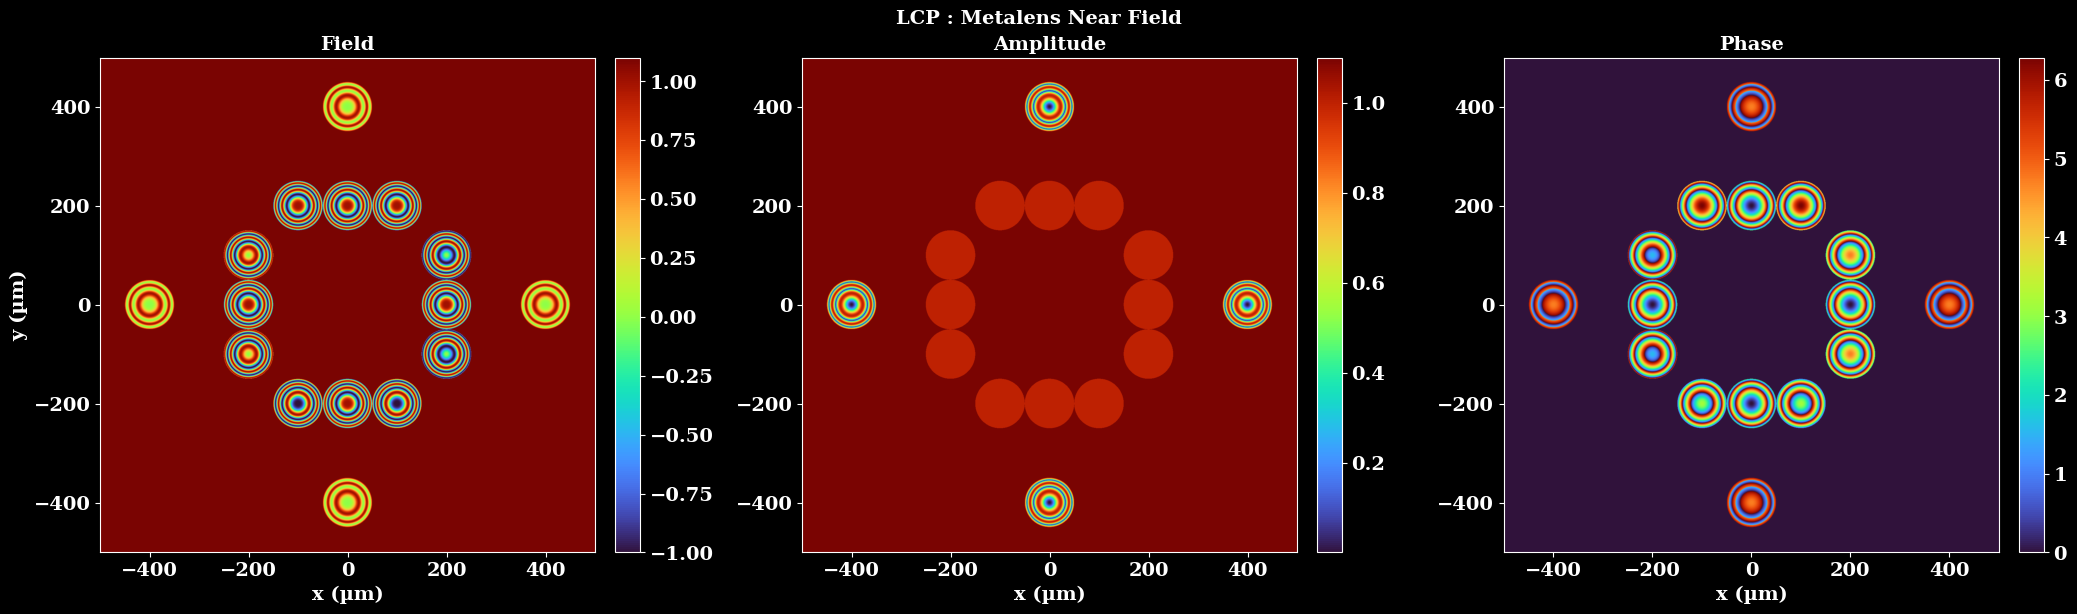

                                                  INCIDENT FIELD                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Attribute              ┃ Value                                       ┃ Unit   ┃ type                   ┃ device ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Propagation wavelength │ 1.31e-06                                    │ m      │ <class 'float'>        │ cpu    │
│ Propagation distance   │ 0.0003938356164383562                       │ m      │ <class 'float'>        │ cpu    │
│ Refractive index       │ 1                                           │        │ <class 'int'>          │ cpu    │
│ Input Size             │ 1539 x 1539                                 │ pixels │ <class 'int'>          │ cpu    │
│ Input Pixel size       │ 6.5e-07                                     │ m      │ <class 'float'>        │ cpu    │
│ Input X                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
│ Input Y                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
└────────────────────────┴─────────────────────────────────────────────┴────────┴────────────────────────┴────────┘

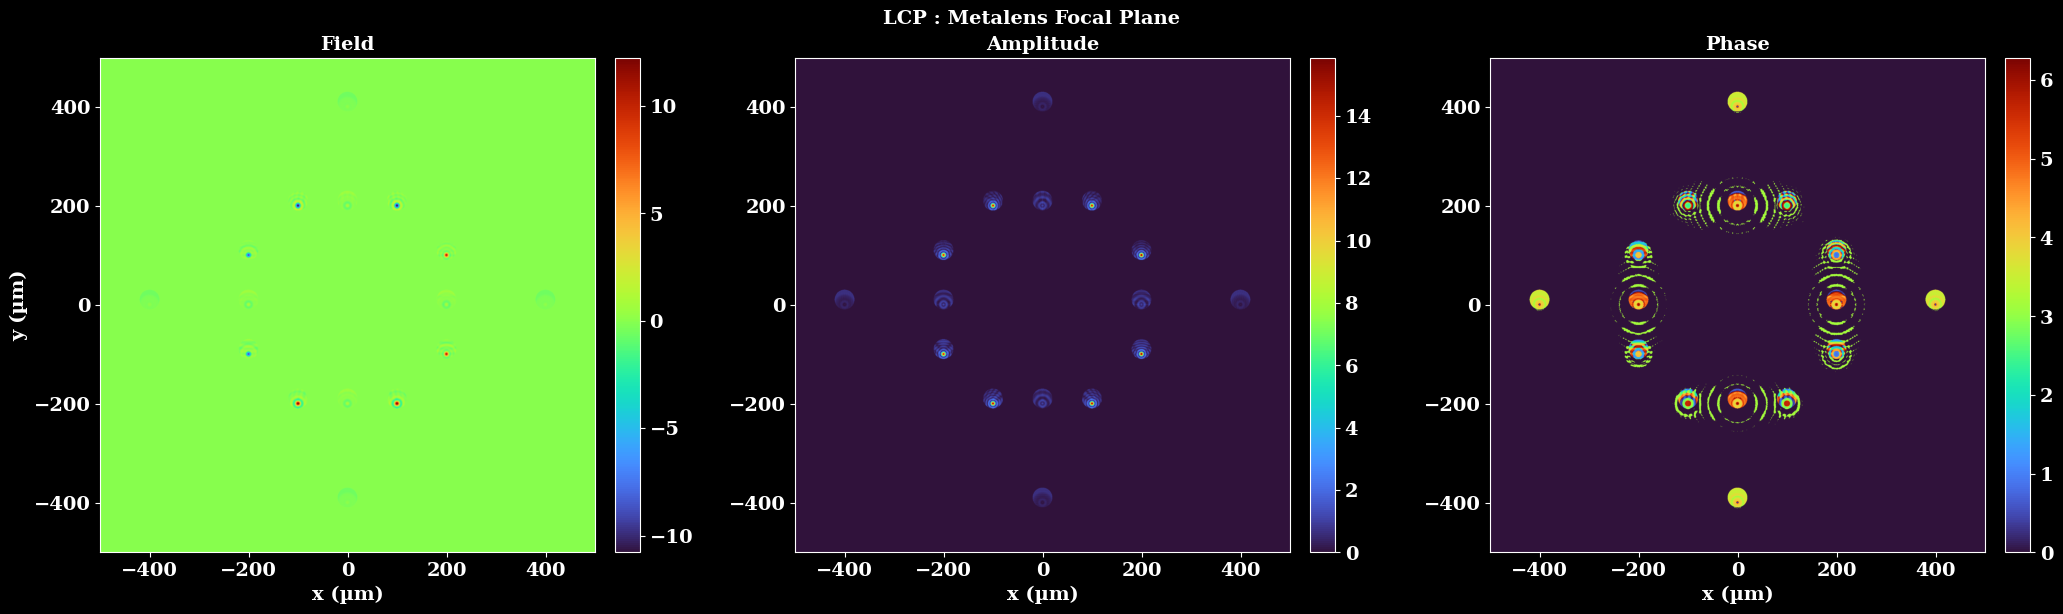

                                                  INCIDENT FIELD                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Attribute              ┃ Value                                       ┃ Unit   ┃ type                   ┃ device ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Propagation wavelength │ 1.31e-06                                    │ m      │ <class 'float'>        │ cpu    │
│ Propagation distance   │ 0.0003938356164383562                       │ m      │ <class 'float'>        │ cpu    │
│ Refractive index       │ 1                                           │        │ <class 'int'>          │ cpu    │
│ Input Size             │ 1539 x 1539                                 │ pixels │ <class 'int'>          │ cpu    │
│ Input Pixel size       │ 6.5e-07                                     │ m      │ <class 'float'>        │ cpu    │
│ Input X                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
│ Input Y                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
└────────────────────────┴─────────────────────────────────────────────┴────────┴────────────────────────┴────────┘

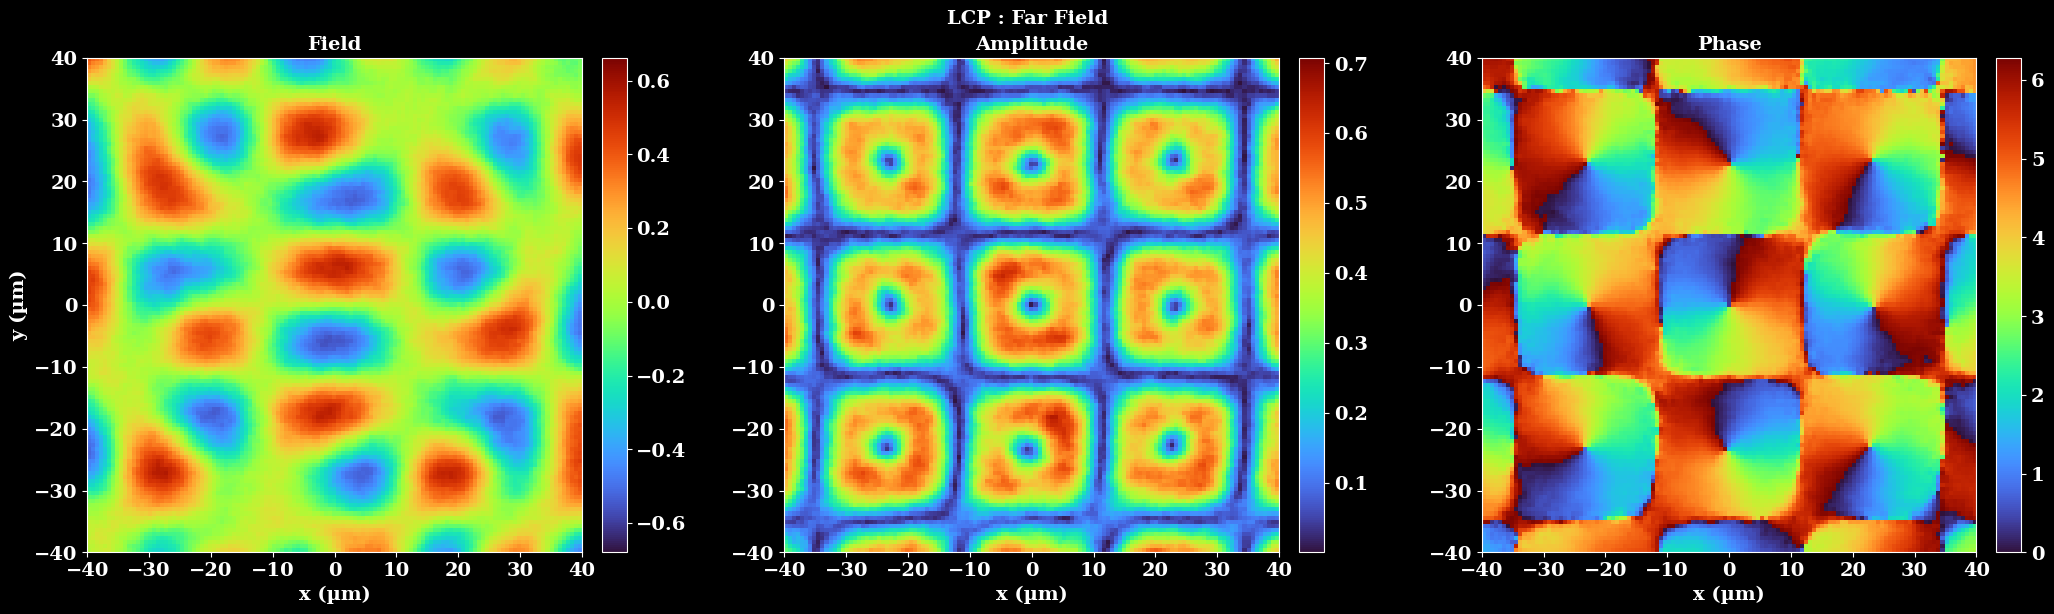

Calculating RCP field...


                                                  INCIDENT FIELD                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Attribute              ┃ Value                                       ┃ Unit   ┃ type                   ┃ device ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Propagation wavelength │ 1.31e-06                                    │ m      │ <class 'float'>        │ cpu    │
│ Propagation distance   │ 0.0003938356164383562                       │ m      │ <class 'float'>        │ cpu    │
│ Refractive index       │ 1                                           │        │ <class 'int'>          │ cpu    │
│ Input Size             │ 1539 x 1539                                 │ pixels │ <class 'int'>          │ cpu    │
│ Input Pixel size       │ 6.5e-07                                     │ m      │ <class 'float'>        │ cpu    │
│ Input X                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
│ Input Y                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
└────────────────────────┴─────────────────────────────────────────────┴────────┴────────────────────────┴────────┘

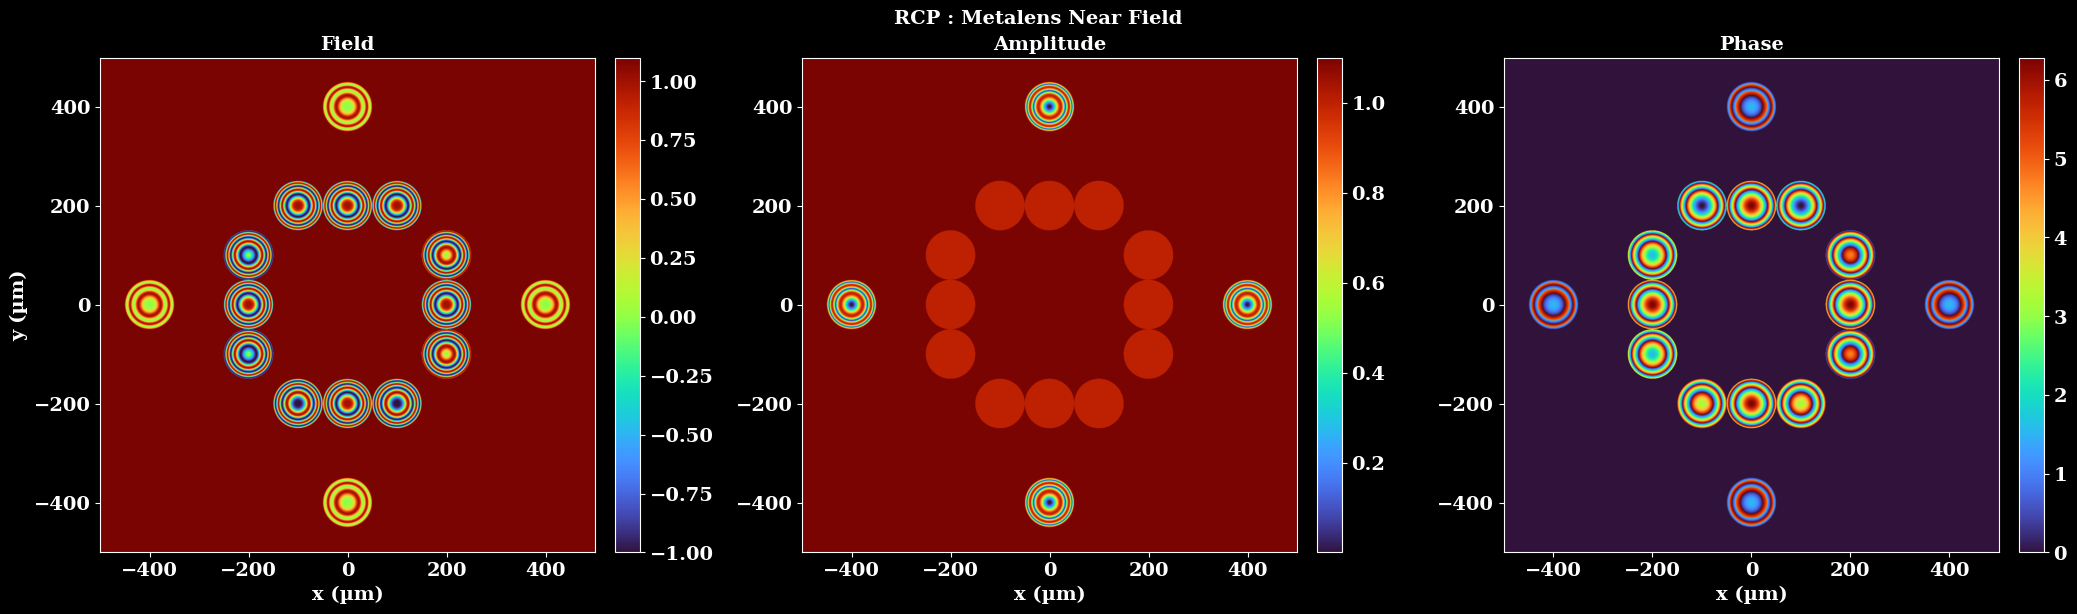

                                                  INCIDENT FIELD                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Attribute              ┃ Value                                       ┃ Unit   ┃ type                   ┃ device ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Propagation wavelength │ 1.31e-06                                    │ m      │ <class 'float'>        │ cpu    │
│ Propagation distance   │ 0.0003938356164383562                       │ m      │ <class 'float'>        │ cpu    │
│ Refractive index       │ 1                                           │        │ <class 'int'>          │ cpu    │
│ Input Size             │ 1539 x 1539                                 │ pixels │ <class 'int'>          │ cpu    │
│ Input Pixel size       │ 6.5e-07                                     │ m      │ <class 'float'>        │ cpu    │
│ Input X                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
│ Input Y                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
└────────────────────────┴─────────────────────────────────────────────┴────────┴────────────────────────┴────────┘

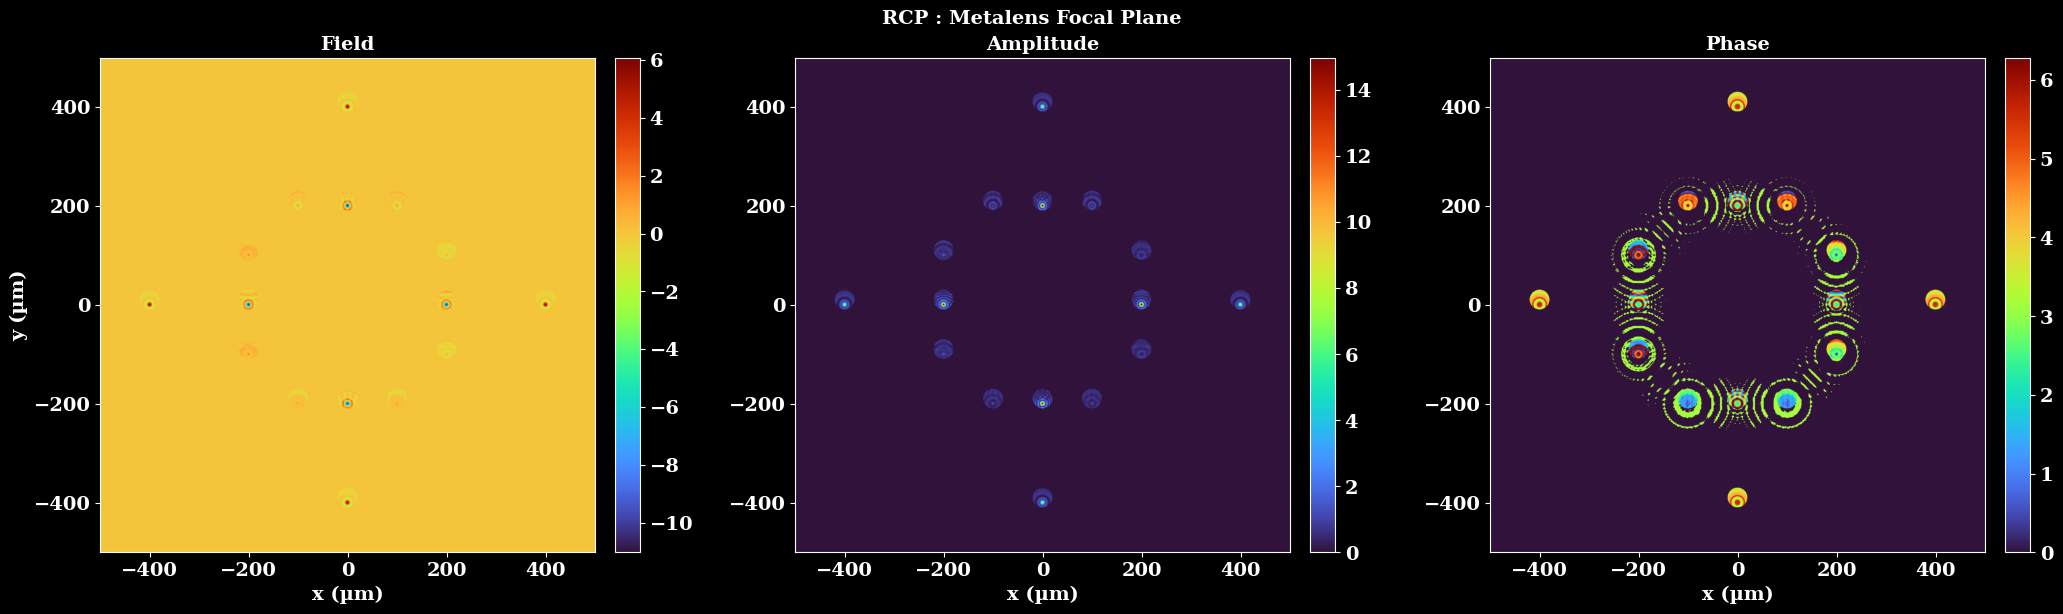

                                                  INCIDENT FIELD                                                   
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃ Attribute              ┃ Value                                       ┃ Unit   ┃ type                   ┃ device ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ Propagation wavelength │ 1.31e-06                                    │ m      │ <class 'float'>        │ cpu    │
│ Propagation distance   │ 0.0003938356164383562                       │ m      │ <class 'float'>        │ cpu    │
│ Refractive index       │ 1                                           │        │ <class 'int'>          │ cpu    │
│ Input Size             │ 1539 x 1539                                 │ pixels │ <class 'int'>          │ cpu    │
│ Input Pixel size       │ 6.5e-07                                     │ m      │ <class 'float'>        │ cpu    │
│ Input X                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
│ Input Y                │ -0.0004998500226065516 ~                    │ m      │ <class 'torch.Tensor'> │ cpu    │
│                        │ 0.0004998500226065516                       │        │                        │        │
└────────────────────────┴─────────────────────────────────────────────┴────────┴────────────────────────┴────────┘

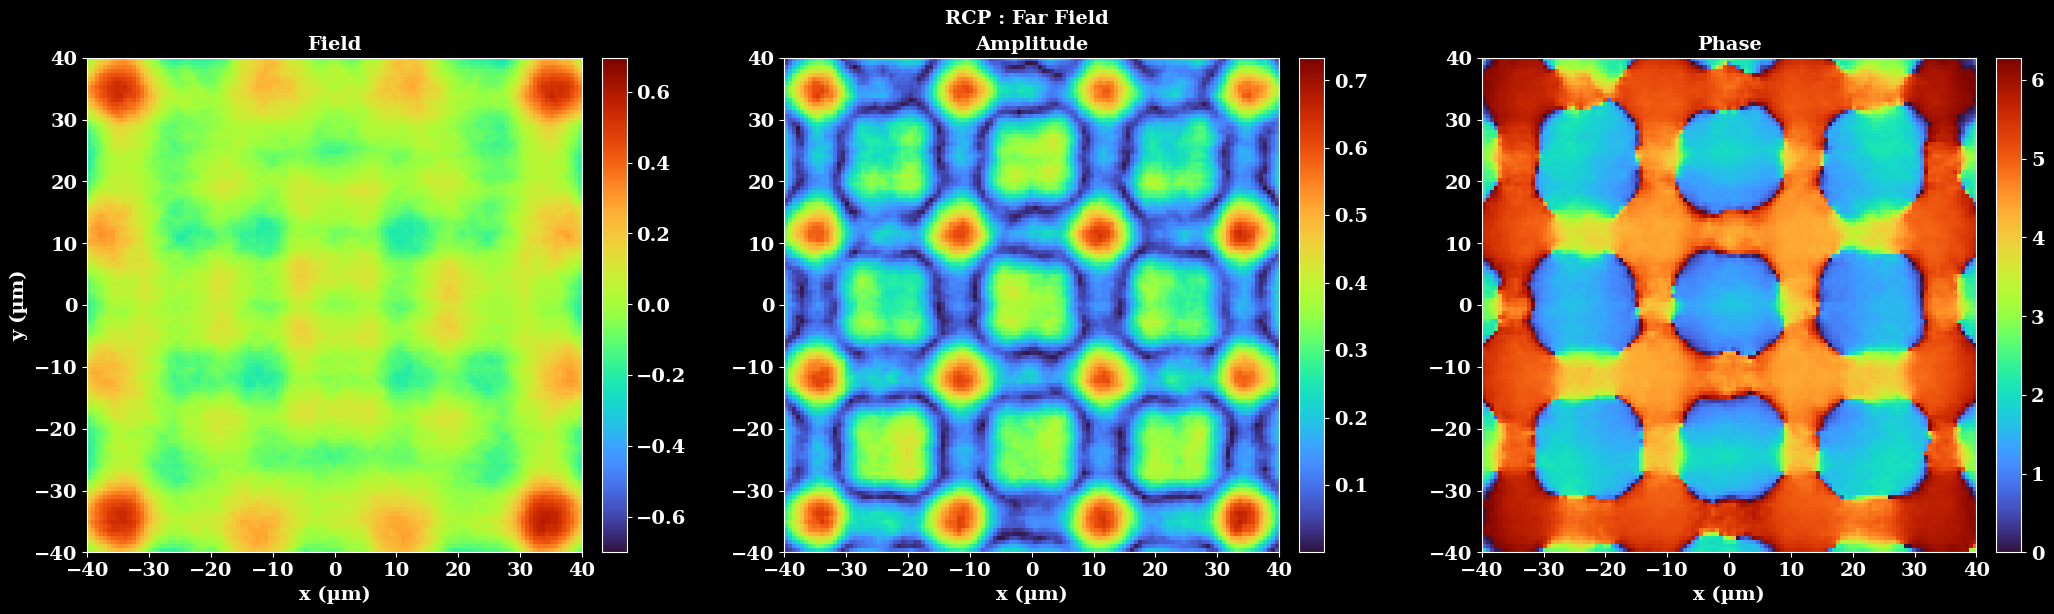

Generating polarization color map...
Simulation completed!
Simulation completed! LCP field shape: torch.Size([1539, 1539]), RCP field shape: torch.Size([1539, 1539])


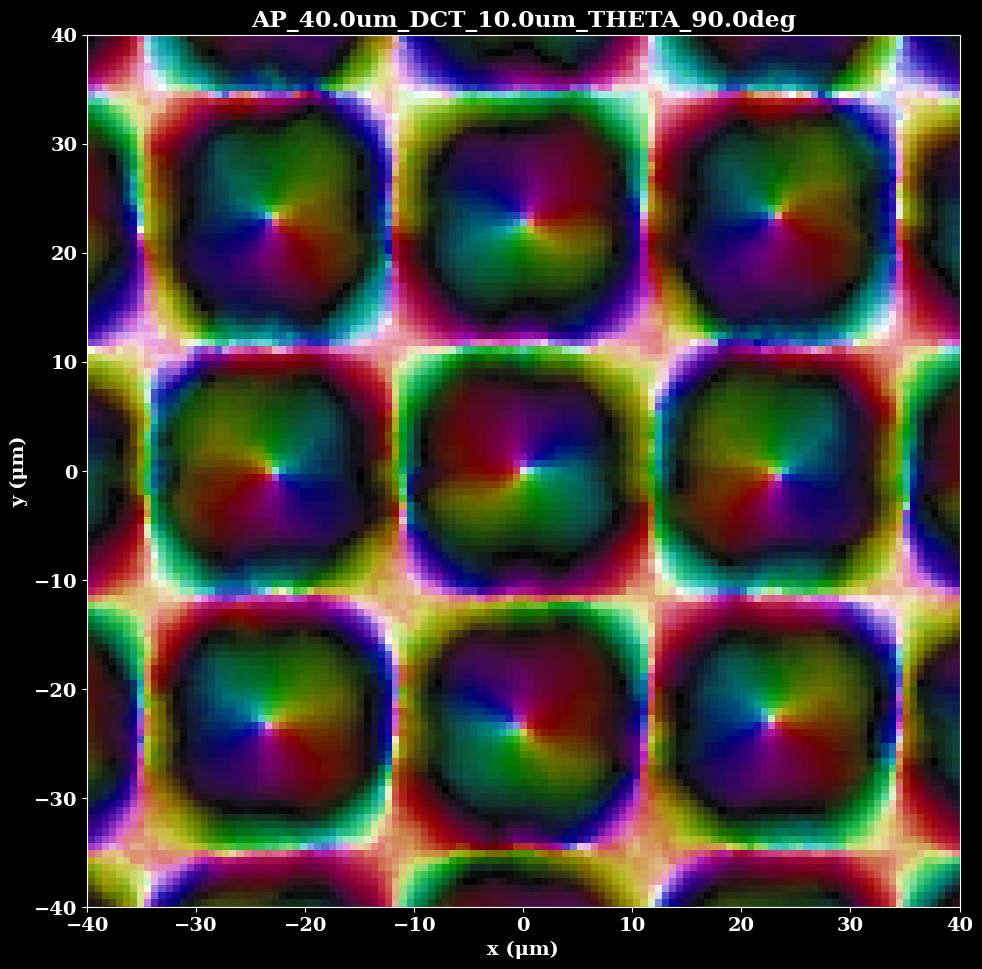

In [4]:
# Create configuration
config = SimulationConfig()

# Create simulator
simulator = HopfionSimulator(config)

# Run simulation
U_LCP, U_RCP = simulator.run_simulation()

print(f"Simulation completed! LCP field shape: {U_LCP.shape}, RCP field shape: {U_RCP.shape}")